## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2020-04-03 12:46:02--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2020-04-03 12:46:02--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7564cdbb4286ced4975c81506f.dl.dropboxusercontent.com/cd/0/inline/A1JUOuuVC1O2SOtWofpBsz8TLA0cDfJVOaJ4GgMzd3y_2MVGfRo6fH3Z_9AKJibrkgJKgSgrMQoQY7uPJ7-GnCQWSRScUGTdcpE2gpA-_Q3EOw/file# [following]
--2020-04-03 12:46:03--  https://uc7564cdbb4286ced4975c81506f.dl.dropboxusercontent.com/cd/0/inline/A1JUOuuVC1O2SOtWofpBsz8TLA0cDfJVOaJ4GgMzd3y_2MVGfRo6fH3Z_9AKJibrkgJKgSgrMQoQY7uPJ7-GnCQWSRScUGTdcpE2gpA-_Q3EOw/file
Resolving uc7564cdbb4286ce

### Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

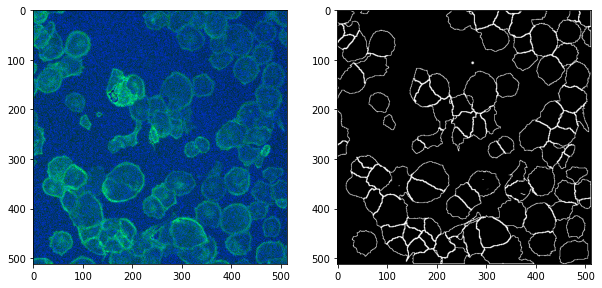

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
import cv2
import glob
import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model Fitting was done on Google Colab with the following GPU:

In [5]:
! nvidia-smi

Fri Apr  3 12:46:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Prepare Data
### Constants

In [0]:
HEIGHT = 512
WIDTH = 512

IMG_PATH = 'BBBC018_v1_images-fixed/'
MASK_PATH = 'BBBC018_v1_outlines/'

TRAIN_IMG_PATH = IMG_PATH + 'train'
TRAIN_MASK_PATH = MASK_PATH + 'train'

VAL_IMG_PATH = IMG_PATH + 'val'
VAL_MASK_PATH = MASK_PATH + 'val'

TEST_IMG_PATH = IMG_PATH + 'test'

### Dataset 

In [0]:
class SegmentationDataset(Dataset):
    def __init__(self, img_path, mask_path, transforms=None):
        self.images = sorted(glob.glob("{}/*".format(img_path)))
        self.masks = sorted(glob.glob("{}/*".format(mask_path)))
        assert len(self.images) == len(self.masks), 'Mismatch in mask and image numbers'
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img = skimage.img_as_ubyte(skimage.io.imread(self.images[idx]))
        mask = skimage.img_as_ubyte(skimage.io.imread(self.masks[idx]))
        
        if self.transforms is not None:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']; mask = augmented['mask']
    
        img = transforms.ToTensor()(img)
        mask = transforms.ToTensor()(mask).squeeze(0)
        
        return (img, mask)
    
    def __len__(self):
        return len(self.images)

### Augmentations
We will define training augmentations using albumentations library. Transofrmations accept both the image and mask which makes it extremely easy to use. Out of the big variety of the augmentations, we will be using RandomSizedCrop, all sorts of flips, one of the more complex ones (ElasticTransform, GridDistortion, OpticalDistortion), and one of the RandomBrightnessContrast and RandomGamma. No hard augmentations were chosen that would change the image dramatically, the parameters were set to small values

In [0]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)


aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(200, 400), height=HEIGHT, width=WIDTH, p=1.),
        PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, p=1.)], p=1),
    VerticalFlip(p=0.5),   
    HorizontalFlip(p=0.5),   
    RandomRotate90(p=0.5),
    Transpose(p=0.25),
    OneOf([
        ElasticTransform(p=0.5, alpha=80, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=0.5, shift_limit=0.5)                  
        ], p=0.8),
    OneOf([
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.),    
        RandomGamma(p=1.)], p=0.8)
])

In [0]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 2, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask, 'gray')
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask, 'gray')
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask, 'gray')
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

Let's visualize one random augmentation

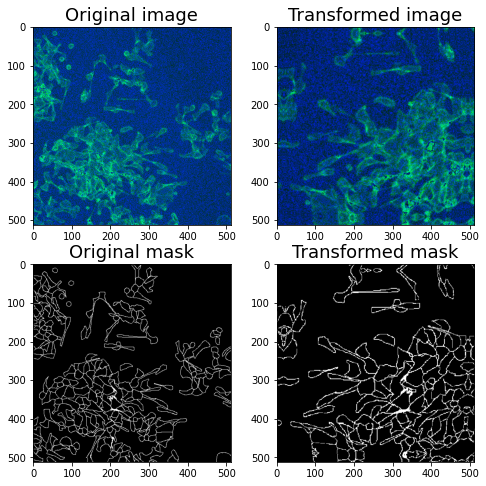

In [57]:
train_dataset = SegmentationDataset(img_path=TRAIN_IMG_PATH,
                                    mask_path=TRAIN_MASK_PATH)

rand_idx = np.random.randint(len(train_dataset))
img = skimage.img_as_ubyte(skimage.io.imread(train_dataset.images[rand_idx]))
mask = skimage.img_as_ubyte(skimage.io.imread(train_dataset.masks[rand_idx]))

augmented = aug(image=img, mask=mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize(image_heavy, mask_heavy, original_image=img, original_mask=mask)

### Combine it all together

In [0]:
train_dataset = SegmentationDataset(img_path=TRAIN_IMG_PATH,
                                    mask_path=TRAIN_MASK_PATH, 
                                    transforms=aug)
val_dataset = SegmentationDataset(img_path=VAL_IMG_PATH,
                                  mask_path=VAL_MASK_PATH)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

## Model
Using Vanilla U-Net

In [0]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512) 

        self.pool = nn.MaxPool2d(2)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.up3 = DoubleConv(256 + 512, 256)
        self.up2 = DoubleConv(128 + 256, 128)
        self.up1 = DoubleConv(64 + 128, 64)
        
        self.out = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, x):
        down1 = self.down1(x)
        x = self.pool(down1)
        down2 = self.down2(x)
        x = self.pool(down2)
        down3 = self.down3(x)
        x = self.pool(down3)
        x = self.down4(x)

        x = self.upsample(x)
        x = torch.cat([x, down3], dim=1)
        x = self.up3(x)
        x = self.upsample(x)
        x = torch.cat([x, down2], dim=1)
        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, down1], dim=1)
        x = self.up1(x)
        
        x = self.out(x)
        
        return x

## Training phase
The final model was trained for 100 epochs using Adam optimizer with default parameters. During one training epoch the model sees augmented training samples for 5 times (N_REPEATS). The model was fitted using the Cross-Entropy Loss for each pixel, thus the model outputs the tensor with number of channels equalling to two, where two here is the number of classes. The script saves the model weights depending on the validation loss

In [0]:
N_EPOCHS = 100
N_REPEATS = 5
SAVE_FILENAME = 'weights.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
opt = torch.optim.Adam(model.parameters())

In [0]:
from torch.autograd import Variable

def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).to(device)
    y_batch = Variable(torch.LongTensor(y_batch.long())).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [64]:
train_losses = []
val_losses = []
best_val_loss = 99999999


for epoch in range(N_EPOCHS):
    print('Epoch {} started...'.format(epoch + 1))
    start_time = time.time()
    model.train()

    epoch_train_losses = []
    for _ in range(N_REPEATS):
        for X_batch, y_batch in train_loader:
            loss = compute_loss(X_batch, y_batch)
            loss.backward()

            opt.step()
            opt.zero_grad()

            epoch_train_losses.append(loss.item())

    train_loss = np.mean(epoch_train_losses)
    train_losses.append(train_loss)
    print('Train Cross-Entropy Loss: {}'.format(train_loss))

    model.eval()

    epoch_val_losses = []
    for X_batch, y_batch in val_loader:
        loss = compute_loss(X_batch, y_batch)
        epoch_val_losses.append(loss.item())

    val_loss = np.mean(epoch_val_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print('    Saving model weights...')
        torch.save(model.state_dict(), SAVE_FILENAME)

    val_losses.append(val_loss)
    print('Val Cross-Entropy Loss: {}'.format(val_loss))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, N_EPOCHS, time.time() - start_time))

Epoch 1 started...
Train Cross-Entropy Loss: 0.2153795016663415
    Saving model weights...
Val Cross-Entropy Loss: 0.17691118642687798
Epoch 1 of 100 took 32.242s
Epoch 2 started...
Train Cross-Entropy Loss: 0.1258264850292887
    Saving model weights...
Val Cross-Entropy Loss: 0.15360087901353836
Epoch 2 of 100 took 33.003s
Epoch 3 started...
Train Cross-Entropy Loss: 0.11207605004310608
    Saving model weights...
Val Cross-Entropy Loss: 0.14944013953208923
Epoch 3 of 100 took 32.626s
Epoch 4 started...
Train Cross-Entropy Loss: 0.11021677448990799
    Saving model weights...
Val Cross-Entropy Loss: 0.14384598843753338
Epoch 4 of 100 took 32.317s
Epoch 5 started...
Train Cross-Entropy Loss: 0.10451517513110524
Val Cross-Entropy Loss: 0.14530855044722557
Epoch 5 of 100 took 32.586s
Epoch 6 started...
Train Cross-Entropy Loss: 0.10529598320523897
    Saving model weights...
Val Cross-Entropy Loss: 0.1406076792627573
Epoch 6 of 100 took 33.454s
Epoch 7 started...
Train Cross-Entropy Lo

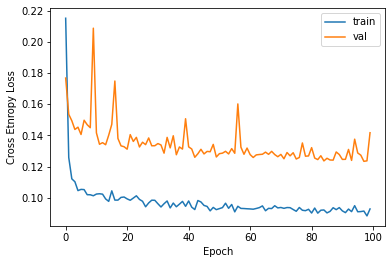

In [65]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cross Etnropy Loss")
plt.legend()

plt.show()

## Validation score
Let's load the best weights on validation

In [66]:
model = UNet().to(device)
model.load_state_dict(torch.load('weights.pth'))

<All keys matched successfully>

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

Calculate IoU for validation samples and visualize predictions:      
Threshold of 0.25 was chosen to fight class imbalance

Validation IoU: 0.314


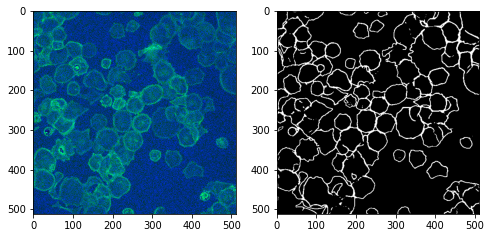

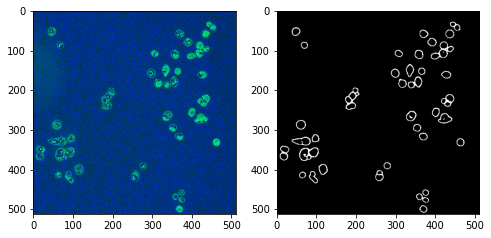

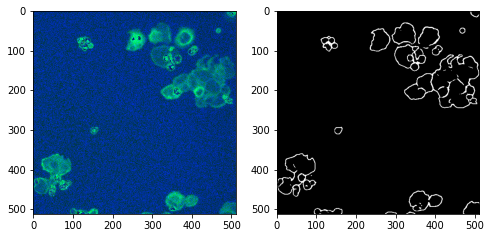

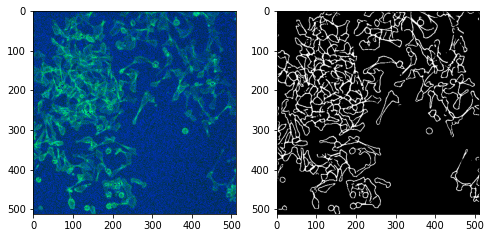

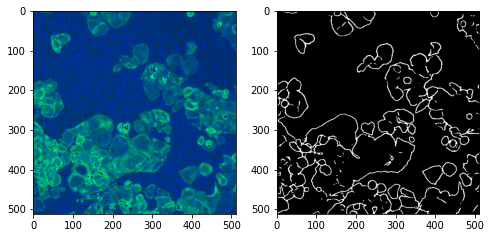

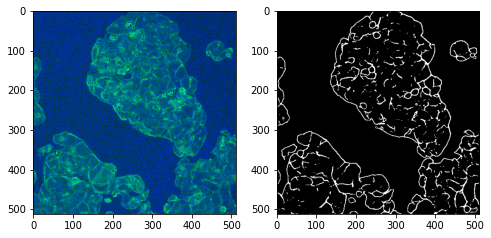

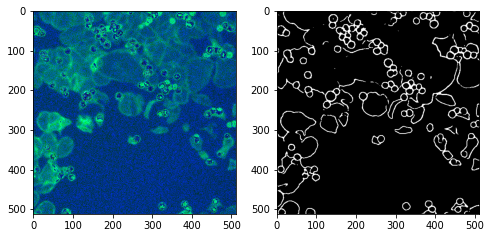

In [81]:
prediction = []
ground_truth = []
THRESHOLD = 0.25

for img, mask in val_dataset:

    target = mask.data.numpy()
    out = model(img.unsqueeze(0).to(device)).cpu()

    predict = F.softmax(out, dim=1).data.numpy()[0][1]
    mask = (predict > THRESHOLD).astype(int)

    prediction.append(mask)
    ground_truth.append(target)

    image = img.data.numpy().transpose(1, 2, 0)
    visualize(image, mask)

iou = calc_iou(prediction, ground_truth)
    
print("Validation IoU: {:.3f}".format(iou))

## Predict test samples

In [0]:
class TestSegmentationDataset(Dataset):
    def __init__(self, img_path):
        self.images = sorted(glob.glob("{}/*".format(img_path)))
    
    def __getitem__(self, idx):
        img = skimage.img_as_ubyte(skimage.io.imread(self.images[idx]))
        img = transforms.ToTensor()(img)
        
        return img, self.images[idx]
    
    def __len__(self):
        return len(self.images)

Creating out folder where to put the test samples' masks

In [0]:
! mkdir out

Saving and visualizing for each test sample:

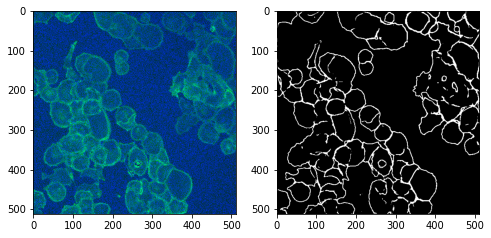

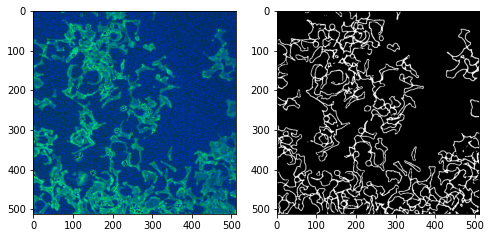

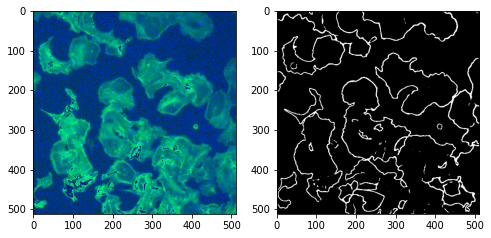

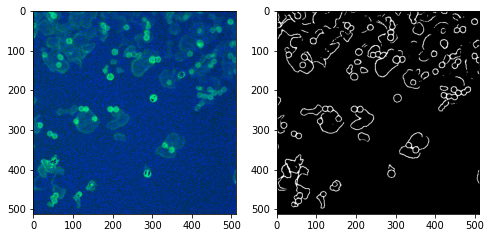

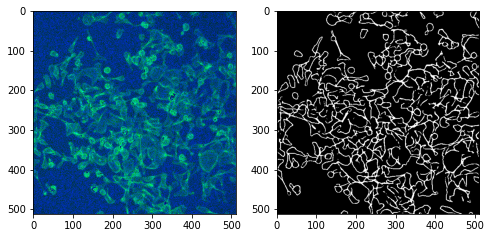

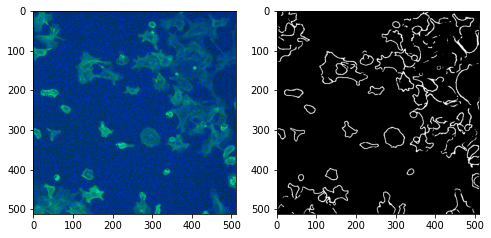

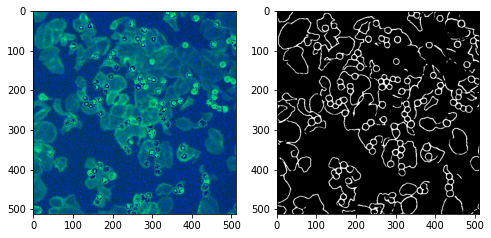

In [106]:
import imageio

test_dataset = TestSegmentationDataset(TEST_IMG_PATH)

for img, path in test_dataset:
    out = model(img.unsqueeze(0).to(device)).cpu()
    predict = F.softmax(out, dim=1).data.numpy()[0][1]
    mask = (predict > THRESHOLD).astype(int)
    
    image = img.data.numpy().transpose(1, 2, 0)
    visualize(image, mask)

    save_path = 'out/' + path.split('/')[2][:-3] + 'png'
    mask = (mask * 255).astype(np.uint8)
    imageio.imwrite(save_path, mask)

Archiving the 'out' folder to submit it to anytask

In [107]:
! zip -r masks.zip out/

  adding: out/ (stored 0%)
  adding: out/13569-actin.DIB.png (stored 0%)
  adding: out/13361-actin.DIB.png (stored 0%)
  adding: out/05899-actin.DIB.png (stored 0%)
  adding: out/00733-actin.DIB.png (stored 0%)
  adding: out/19466-actin.DIB.png (stored 0%)
  adding: out/10780-actin.DIB.png (deflated 0%)
  adding: out/05624-actin.DIB.png (stored 0%)
